In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
import os
import cv2
import glob
import matplotlib.pyplot as plt
import scipy.ndimage

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout, Activation, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras import backend as K
from focal_loss import BinaryFocalLoss

c:\Users\Jett\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Load the .h5 file
image_folder = "/VSCode/Senior Project/TrainData/img"
mask_folder = "/VSCode/Senior Project/TrainData/mask"

image_files = sorted(glob.glob(os.path.join(image_folder, "*.h5")))
mask_files = sorted(glob.glob(os.path.join(mask_folder, "*.h5")))

image_files = image_files[:2500]
mask_files = mask_files[:2500]

images = []
masks = []

images_training = []
masks_training =[]
testing_images = []
testing_masks = []

for img_path, mask_path in zip(image_files, mask_files):

    # Load image
    with h5py.File(img_path, "r") as img_file:
        if "img" in img_file:
            image_data = img_file["img"][:]
            images.append(image_data)
        else:
            print(f"No dataset named 'data' found in {img_path}")
    
    # Load mask
    with h5py.File(mask_path, "r") as mask_file:
        if "mask" in mask_file:
            mask_data = mask_file["mask"][:]
            masks.append(mask_data)
        else:
            print(f"No dataset named 'data' found in {mask_path}")

images = np.array(images)
masks = np.array(masks)

print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

Images shape: (2500, 128, 128, 14)
Masks shape: (2500, 128, 128)


In [ ]:
# Separate training and testing images
training_images = np.array(images[:2000])
training_masks = np.array(masks[:2000])

testing_images = np.array(images[2000:2500])
testing_masks = np.array(masks[2000:2500])
print(training_images.shape)

(2000, 128, 128, 14)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


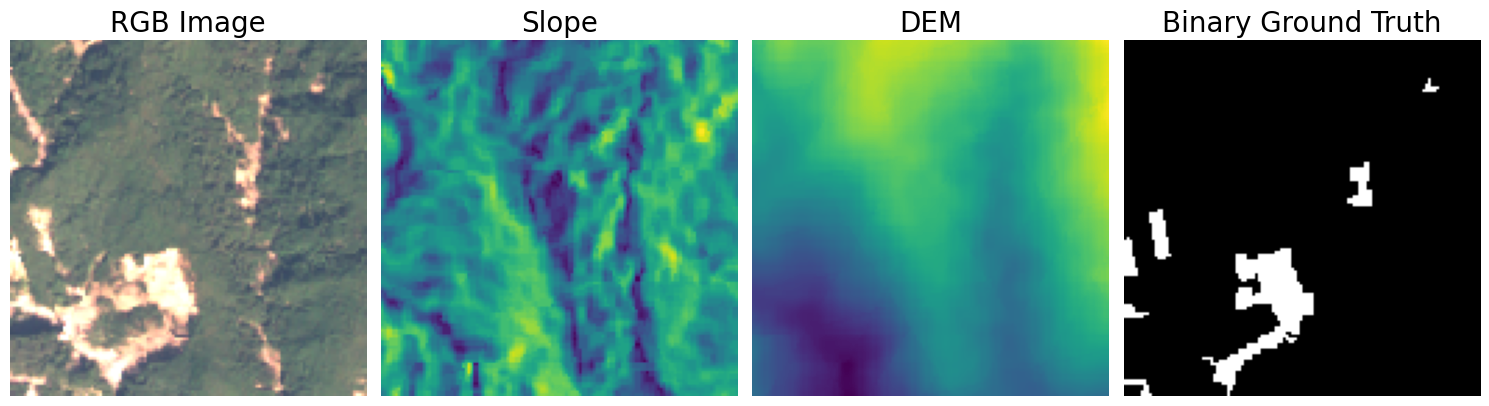

In [ ]:
# Display samples from dataset
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

idx = 100

rgb_sample = training_images[idx]

rgb_image = np.stack([
    rgb_sample[:, :, 3],
    rgb_sample[:, :, 2],
    rgb_sample[:, :, 1]
], axis=-1)
rgb_image = rgb_image * 0.6
axs[0].imshow(rgb_image)
axs[0].set_title("RGB Image", fontsize=20)
axs[0].axis('off')

axs[1].imshow(training_images[idx, :, :, 12])
axs[1].set_title("Slope", fontsize=20)
axs[1].axis("off")

axs[2].imshow(training_images[idx, :, :, 13])
axs[2].set_title("DEM", fontsize=20)
axs[2].axis("off")

axs[3].imshow(training_masks[idx], cmap='gray')
axs[3].set_title("Binary Ground Truth", fontsize=20)
axs[3].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Definitions for each function

def conv_block(inputs, filters, kernel_size=(3,3), padding="same"):
    x = layers.Conv2D(filters, kernel_size, padding=padding, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size, padding=padding, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet_plus_plus(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoding Path
    x_00 = conv_block(inputs, 64)
    x_10 = conv_block(MaxPooling2D()(x_00), 128)
    x_20 = conv_block(MaxPooling2D()(x_10), 256)
    x_30 = conv_block(MaxPooling2D()(x_20), 512)
    x_40 = conv_block(MaxPooling2D()(x_30), 1024)
 
    # Decoding Path
    x_01 = conv_block(concatenate(
        [x_00, UpSampling2D()(x_10)]), 64)
    x_11 = conv_block(concatenate(
        [x_10, UpSampling2D()(x_20)]), 128)
    x_21 = conv_block(concatenate(
        [x_20, UpSampling2D()(x_30)]), 256)
    x_31 = conv_block(concatenate(
        [x_30, UpSampling2D()(x_40)]), 512)
 
    x_02 = conv_block(concatenate(
        [x_00, x_01, UpSampling2D()(x_11)]), 64)
    x_12 = conv_block(concatenate(
        [x_10, x_11, UpSampling2D()(x_21)]), 128)
    x_22 = conv_block(concatenate(
        [x_20, x_21, UpSampling2D()(x_31)]), 256)
 
    x_03 = conv_block(concatenate(
        [x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
    x_13 = conv_block(concatenate(
        [x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)
 
    x_04 = conv_block(concatenate(
        [x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), 64)

    # Output layer
    outputs = Conv2D(1, (1,1), activation="sigmoid")(x_04)

    model = Model(inputs, outputs)
    return model

def iou_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

def resize_patch(image, target_size):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

# recall 
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_score_custom(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2 * (precision * recall) / (precision + recall + K.epsilon())

In [ ]:
# Split data into training and testing
X_train, X_val, y_train, y_val = train_test_split(training_images, training_masks, test_size=0.2, shuffle=True, random_state=40)

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)

# Standardize per channel
mean = X_train.mean(axis=(0,1,2))
std = X_train.std(axis=(0,1,2))

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

# Need to make validation like (num_samples, 128, 128, 1)
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

# Instantiate the model
input_shape = (128, 128, 14)
#model = unet_model(input_shape)
model = unet_plus_plus(input_shape)

# Compile model for training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=False),
              metrics=['accuracy', f1_score_custom, iou_metric])

# Save model at each epoch
checkpoint_path = '/VSCode/Senior Project/TrainedModels/M_models/M_model_epoch_{epoch:02d}.keras'
checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=False, save_best_only=False, verbose=1)

# Data augmentation function
def augment_image_and_mask(image, mask):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, mask

# Create training and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(augment_image_and_mask).batch(32).shuffle(100)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

# Training
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[checkpoint]
)

# Save model
model.save('/VSCode/Senior Project/TrainedModels/M_models/M_model.keras')

Epoch 1/100
 2/50 [>.............................] - ETA: 10:01 - loss: 0.2105 - accuracy: 0.7302 - f1_score_custom: 0.0477 - iou_metric: 0.0285

KeyboardInterrupt: 

16/16 [==============================] - 40s 2s/step
Test F1-score: 59.58502956541304


Text(45.72222222222221, 0.5, 'True')

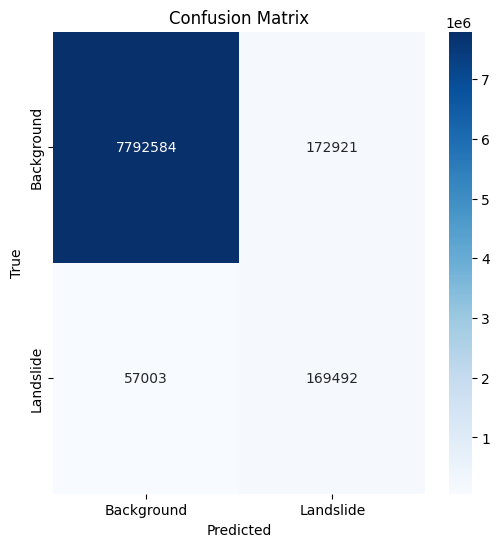

In [ ]:
model_path = '/VSCode/Senior Project/TrainedModels/M_models/M_model_epoch_39.keras'
model = load_model(model_path, custom_objects={'f1_score_custom': f1_score_custom, 'iou_metric': iou_metric})

X_train, X_val, y_train, y_val = train_test_split(training_images, training_masks, test_size=0.2, shuffle=True, random_state=40)

# Standardize per channel
mean = X_train.mean(axis=(0,1,2))
std = X_train.std(axis=(0,1,2))

X_test_norm = (testing_images - mean) / std

# Get predictions for the test set
predicted_masks = model.predict(X_test_norm)
predictions = (predicted_masks > 0.4).astype(np.uint8)
# Flatten arrays for confusion matrix comparison
y_true_flat = testing_masks.flatten()
predictions_flat = predictions.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, predictions_flat)

f1 = f1_score(testing_masks.flatten(), predictions.flatten())
print("Test F1-score:", f1 * 100)

# Show the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Landslide'], yticklabels=['Background', 'Landslide'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


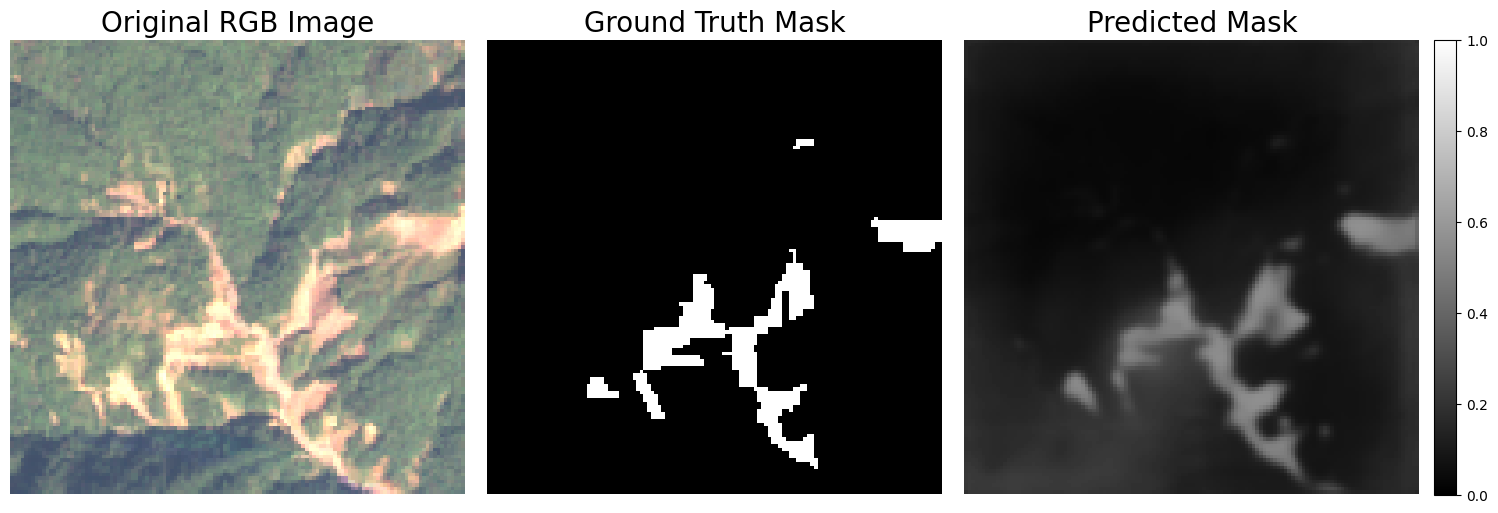

In [ ]:
sample_idx = 224
#sample_idx = 227
#sample_idx = 229

predictions, grayscale = predicted_masks, False
# predictions, grayscale = (predicted_masks > 0.4).astype(np.uint8), True

X_sample = predictions[sample_idx]
RGB_sample = testing_images[sample_idx]
y_sample = testing_masks[sample_idx]

# Display the original image, ground truth, and predicted mask
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

rgb_image = np.stack([
    RGB_sample[:, :, 3],
    RGB_sample[:, :, 2],
    RGB_sample[:, :, 1]
], axis=-1)
rgb_image = rgb_image * 0.6

# Display RGB image
axs[0].imshow(rgb_image)
axs[0].set_title("Original RGB Image", fontsize=20)
axs[0].axis('off')

# Display ground truth mask
axs[1].imshow(y_sample, cmap='gray')
axs[1].set_title("Ground Truth Mask", fontsize=20)
axs[1].axis('off')

if grayscale == False:
    # Display predicted mask
    im = axs[2].imshow(X_sample, cmap='gray', vmin=0, vmax=1)
    axs[2].set_title("Predicted Mask", fontsize=20)
    axs[2].axis('off')
    
    cbar = fig.colorbar(im, ax=axs, location='right', fraction=0.025, pad=0.01)
    
else:
    im = axs[2].imshow(X_sample, cmap='gray')
    axs[2].set_title("Predicted Mask", fontsize=20)
    axs[2].axis('off')

#plt.tight_layout()
plt.show()